<a href="https://colab.research.google.com/github/YaninaK/anomaly-detection/blob/b1/notebooks/03_Anomalies_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обнаружение аномалий в начислениях за тепловую энергию


## 2. Аномалии 3.

### Примеры аномалий

Виды аномалий по показаниям приборов учёта тепловой энергии, которые необходимо выявлять (кроме объектов с видом энергопотребления ГВС (централ):

1. нулевые значения показаний за тепловую энергию в отопительный период (октябрь-апрель);

2. равные значения показаний в течение нескольких расчетных периодов;

3. снижение/рост показаний в отдельные месяцы по сравнению с показаниями за предыдущие периоды по данному объекту (с учётом фактической температуры наружного воздуха и количества отопительных дней в месяце);

4. аномально низкое/высокое (отклонение более 25%) потребление объекта в конкретном месяце по сравнению с аналогичными объектами (только для типов объекта «Многоквартирный дом») по критериям:
  - год постройки (по группам до 1958 г., 1959-1989 гг., 1990-2000 гг., 2001-2010 гг., 2011-2024 гг.),
  - этажность (по группам 1-2 этажа, 3-4 этажа, 5-9 этажей,10-12 этажей, 13 и более этажей),
  - площадь (±10%),
  - наличие ГВС ИТП (горячей воды, учитываемой тем же прибором).

In [1]:
initiate = False
if initiate:
  !git init -q
  !git clone -b b1  https://github.com/YaninaK/anomaly-detection.git -q

  from google.colab import drive
  drive.mount('/content/drive')

  !unzip -u -q /content/drive/MyDrive/ML_projects/08_anomaly_detection/data/01_raw/task#3.zip -d /content/anomaly-detection/data/01_raw

%cd /content/anomaly-detection/notebooks

/content/anomaly-detection/notebooks


In [2]:
import os
import sys

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "..", "src", "anomaly_detection"))

In [3]:
import datetime
import random
import tempfile

import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from data.make_dataset import load_data
from data.preprocess import Preprocess
from data.data_sequence import generate_data_sequence
from features.missing_records import (
    select_missing_records, select_uninvoiced_objects, select_nonunique_objects
)
from features.duplicated import get_equal_values
from features.objects_grouping import ObjectsGrouping
from features.model_inputs import Generator

from models.LSTM_model import get_model
from models.utilities import plot_loss, plot_metrics

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
PATH = "/content/anomaly-detection/"

## 1. Чтение данных

In [6]:
folder_path = '../data/01_raw/'

In [7]:
regenerate = True
data, temperature, buildings = load_data(folder_path, regenerate, path=PATH)

100%|██████████| 24/24 [00:15<00:00,  1.56it/s]


## 2. Подготовка данных

In [8]:
preprocess = Preprocess()
data, buildings, temperature = preprocess.fit_transform(data, buildings, temperature)

data.shape

(75385, 10)

In [9]:
df = generate_data_sequence(data)

print(f"df.shape = {df.shape}\n")
df.sample(2)

df.shape = (4628, 24)



,,,,,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,...,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01
Адрес объекта,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Адрес объекта 2,,,,,,,,,,,,,,,,,,,,,
"г Уфа, ул. Максима Рыльского, д.4 корп.1",Другое строение,1542664,0,"г Уфа, ул. Максима Рыльского, д.4 корп.1",NaN,NaN,3.94,48.547,74.170,91.575,124.644,103.420,86.35,60.040,...,0.0,37.588,75.880,118.640,134.91,100.896,78.797,49.193,0.000,NaN
"г Уфа, ул. Первомайская, д.4",Другое строение,196040,1,"г Уфа, ул. Первомайская, д.4",NaN,0.0,0.00,16.997,26.234,32.237,41.886,36.031,31.79,25.925,...,NaN,19.537,28.648,42.596,42.82,40.781,28.770,29.352,2.413,0.916


In [10]:
temperature.sample(2)

Период,"Тн.в, град.С",ОЗП,Число дней
index,,,
2022-09-01,25.00000,0,34.0
2023-04-01,7.81875,1,32.0


In [11]:
n_periods = len(df)
df.iloc[:, -n_periods:] = np.where(df.iloc[:, -n_periods:] == 0, np.nan, df.iloc[:, -n_periods:])
df /= temperature["Число дней"]

print(f"df.shape = {df.shape}\n")
df.sample(2)

df.shape = (4628, 24)



,,,,,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,...,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01
Адрес объекта,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Адрес объекта 2,,,,,,,,,,,,,,,,,,,,,
"г Уфа, ул. Энтузиастов, д.16, Подобъект №984024",Многоквартирный дом,0121007ВЕ1736/0121307ВЕ1736/0122107ВЕ1736,0,"г Уфа, ул. Энтузиастов, д.16",NaN,NaN,NaN,0.049103,NaN,0.256000,0.404806,0.290714,0.179355,0.085588,...,NaN,0.072222,0.198710,0.364333,0.397097,0.308621,0.201333,0.072500,NaN,NaN
"г Уфа, ул. Кольцевая, д.138 корп.1",Многоквартирный дом,89648,0,"г Уфа, ул. Кольцевая, д.138 корп.1",NaN,NaN,NaN,1.540000,1.954839,2.368667,2.980968,2.493571,2.383935,1.522500,...,NaN,1.187037,1.922516,2.936100,2.925484,2.602586,1.955200,1.423656,NaN,NaN


## 3. Сопоставление данных о потребленнии теплоэнергии и данных об объектах

### 3.1 Более одного объекта на одном ```№ ОДПУ```

In [12]:
df_comb = (
    buildings.merge(
        df.reset_index(),
        left_on=["Тип Объекта", "Адрес объекта 2"],
        right_on=["Тип объекта", "Адрес объекта 2"],
        how="right",
    )
    .drop_duplicates(
        subset=["Адрес объекта_y", "Тип объекта", "№ ОДПУ", "Вид энерг-а ГВС"],
        keep=False,
    )
)
df_comb.shape[0] - df.shape[0]

-74

* У 74 объектов типа ```Другое строение```  на один ```№ ОДПУ``` привязано более одного объекта разной этажности. Эти объекты исключены из обучающей выборки.

### 3.2 Отсутствуют данные об объектах

In [13]:
selected = ["Адрес объекта", "Тип объекта", "№ ОДПУ", "Вид энерг-а ГВС"]
(
    df_comb[df_comb["Адрес объекта_x"].isnull()]
    .rename(columns={"Адрес объекта_y": "Адрес объекта"})[selected]
    .sort_values(by=["Тип объекта", "Адрес объекта"])
    .reset_index(drop=True)
)

,Адрес объекта,Тип объекта,№ ОДПУ,Вид энерг-а ГВС
0,"г Уфа, ул. Новоженова, д.88 корп.литер 1, Подо...","Административные здания, конторы",255257,0
1,г Уфа,Другое строение,787,1
2,"г Уфа, пр-кт Октября, д.18 корп.3а",Другое строение,247280,0
3,"г Уфа, ул. Войкова, д.2",Другое строение,103243,0
4,"г Уфа, ул. Дмитрия Донского, д.1 корп.4",Другое строение,189082,0
5,"г Уфа, ул. Кислородная, д.7, Подобъект №983475",Другое строение,1600800,0
6,"г Уфа, ул. Кулибина, д.40",Другое строение,1108050,0
7,"г Уфа, ул. Максима Горького, д.69 корп.1",Другое строение,98266,0
8,"г Уфа, ул. Николая Дмитриева, д.19 корп.1",Другое строение,1544202,0
9,"г Уфа, ул. Пархоменко, д.125",Другое строение,1668,0


* У 24 объектах из данных о потреблении теплоэнергии отсутствуют данные в базе объектов. Эти объекты исключены из обучающей выборки

In [14]:
df_comb = df_comb[df_comb["Адрес объекта_x"].notnull()].reset_index(drop=True)

df_comb.shape[0] - df.shape[0]

-98

In [15]:
df_comb.shape

(4530, 34)

## 4. Формирование обучающей и тестовой выборки

### 4.1 Формирование датасета

In [16]:
df_stat = df_comb[
    [
        "Адрес объекта 2",
        "Тип объекта",
        "№ ОДПУ",
        "Вид энерг-а ГВС",
        "Этажность объекта",
        "Дата постройки",
        "Общая площадь объекта",
    ]
]
df_stat.sample(2)

,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта
3645,"г Уфа, ул. Российская, д.62 корп.а",Другое строение,180454,1,1.0,NaT,0.01
481,"г Уфа, пр-кт Октября, д.57",Многоквартирный дом,16027235,0,12.0,1969-01-01,4502.70


In [17]:
n_periods = 24
df_seq = df_comb.iloc[:, -n_periods:] / temperature["Число дней"]

df_seq.sample(2)

,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,...,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01
3681,NaN,NaN,NaN,0.098961,0.168315,0.223469,0.268070,0.271394,0.203311,0.095416,...,NaN,0.088063,0.179846,0.262949,0.264508,0.251583,0.182003,0.082740,NaN,NaN
284,NaN,NaN,NaN,0.012333,0.027801,0.036656,0.038142,0.032265,0.030018,0.012849,...,NaN,0.024213,0.024653,0.040801,0.039373,0.036867,0.024460,0.013896,NaN,NaN


### 4.2 Выбор длины последовательности

In [18]:
def get_max_sequence_length(x):
  max_length = 0
  current_length = 0
  for number in x:
    if np.isnan(number):
      current_length = 0
    else:
      current_length += 1
    if current_length > max_length:
        max_length = current_length

  return max_length

In [19]:
n = df_seq.shape[0]
seq_length = df_seq.T.apply(get_max_sequence_length)
print(f"Всего {n} объектов")
print(f"Потеря объектов обучающей выборки при длине непрерывной последовательности:")
for i in range(3, 8):
  print(f"{i}: {n - df_seq[seq_length >= i].shape[0]}")

Всего 4530 объектов
Потеря объектов обучающей выборки при длине непрерывной последовательности:
3: 131
4: 201
5: 271
6: 358
7: 509


* Оптимальная длина последовательности - 4: по трем точкам будем предсказвыать четвертую.

In [20]:
seq_length = 4

### 4.3 Создание обучающей, тестовой и валидационной выборок

* Для тестирования модели оставим 4 месяца: два - в отопительный сезон, два - за пределами отопительного сезона.
* Для валидации - один месяц.

In [21]:
t, v = 4, 1
train = df_seq.iloc[:,:-t-v]
valid = df_seq.iloc[:, -t-v-seq_length+1:-t]
test = df_seq.iloc[:,-t-seq_length+1:]


print(f"Обучающая выборка с{train.columns[0]: '%Y-%m'}до{train.columns[-1]: '%Y-%m'}")
print(f"Валидационная выборка с{valid.columns[0]: '%Y-%m'}до{valid.columns[-1]: '%Y-%m'}")
print(f"Тестовая выборка с{test.columns[0]: '%Y-%m'}до{test.columns[-1]: '%Y-%m'}\n")

train.shape, valid.shape, test.shape

Обучающая выборка с '2021-07'до '2023-01'
Валидационная выборка с '2022-11'до '2023-02'
Тестовая выборка с '2022-12'до '2023-06'



((4530, 19), (4530, 4), (4530, 7))

### 4.4. Нормализация температуры

In [22]:
temperature["t_scaled"] = np.nan
t_ = temperature["Тн.в, град.С"].values.reshape(-1, 1)
scaler = MinMaxScaler()
temperature.iloc[:-t, -1] = scaler.fit_transform(t_[:-t])
temperature.iloc[-t:, -1] = scaler.transform(t_[-t:])
temperature.sample(3)

Период,"Тн.в, град.С",ОЗП,Число дней,t_scaled
index,,,,
2023-06-01,25.000000,0,30.0,1.000000
2023-03-01,-2.266667,1,30.0,0.277612
2022-02-01,-6.735714,1,28.0,0.159211


### 4.5. Cтатические признаки

In [23]:
grouping = ObjectsGrouping()
df_stat = grouping.fit_transform(df_stat)

df_stat.sample(2)

,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта,Группа этажность объекта,Улица,Дата постройки 2,Группа год постройки,Группа общая площадь объекта
1009,"г Уфа, ул. Ахметова, д.324",Многоквартирный дом,200858,0,5.0,1976-01-01,4134.1,5-9 этажей,ул. Ахметова,1976-01-01,1959-1989 гг.,4300
1723,"г Уфа, ул. Интернациональная, д.167",Многоквартирный дом,00067902,0,9.0,1975-01-01,2308.3,5-9 этажей,ул. Интернациональная,1975-01-01,1959-1989 гг.,2800


### 4.6. Tensorflow dataset

In [24]:
%%time
generator = Generator()
ds_train = generator.fit_transform(train, temperature, df_stat, path=PATH, file_name="train_df.parquet.gzip")
ds_valid = generator.fit_transform(valid, temperature, df_stat, path=PATH, file_name="valid_df.parquet.gzip")
ds_test = generator.fit_transform(test, temperature, df_stat, path=PATH, file_name="test_df.parquet.gzip")

CPU times: user 13.7 s, sys: 251 ms, total: 14 s
Wall time: 14.2 s


In [25]:
ds_train.batch(1).take(1)

<_TakeDataset element_spec=({'n_floors': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'area': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'area_group': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'object_type': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'floor_group': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'year_group': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'street': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'gvs': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'LSTM input': TensorSpec(shape=(None, 4, 3), dtype=tf.float64, name=None)}, TensorSpec(shape=(None, 4, 3), dtype=tf.float64, name=None))>

In [26]:
#next(iter(ds_train.take(1)))
#list(ds_train.as_numpy_iterator())

## 5. Модель

In [27]:
model = get_model(df_stat, model_type="autoencoder")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ object_type (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_prep          │ (None, 1)              │              0 │ object_type[0][0]      │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_prep               │ (None, 1)              │              0 │ street[0][0]           │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_emb           │ (None, 1, 5)           │            110 │ object_type_prep[0][0] │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_emb (Embedding)    │ (None, 1, 15)          │          3,315 │ street_prep[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_dense (Dense) │ (None, 1, 2)           │             12 │ object_type_emb[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ floor_group (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ year_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_dense (Dense)      │ (None, 1, 8)           │            128 │ street_emb[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM input (InputLayer)   │ (None, 4, 3)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors_prep             │ (None, 1)              │              3 │ n_floors[0][0]         │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_prep (Normalization) │ (None, 1)              │              3 │ area[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group_prep           │ (None, 11)             │              0 │ area_group[0][0]       │
│ (IntegerLookup)           │                        │                │                        │
├──────────────────────

 Total params: 8,054 (31.47 KB)

 Trainable params: 8,048 (31.44 KB)

 Non-trainable params: 6 (32.00 B)

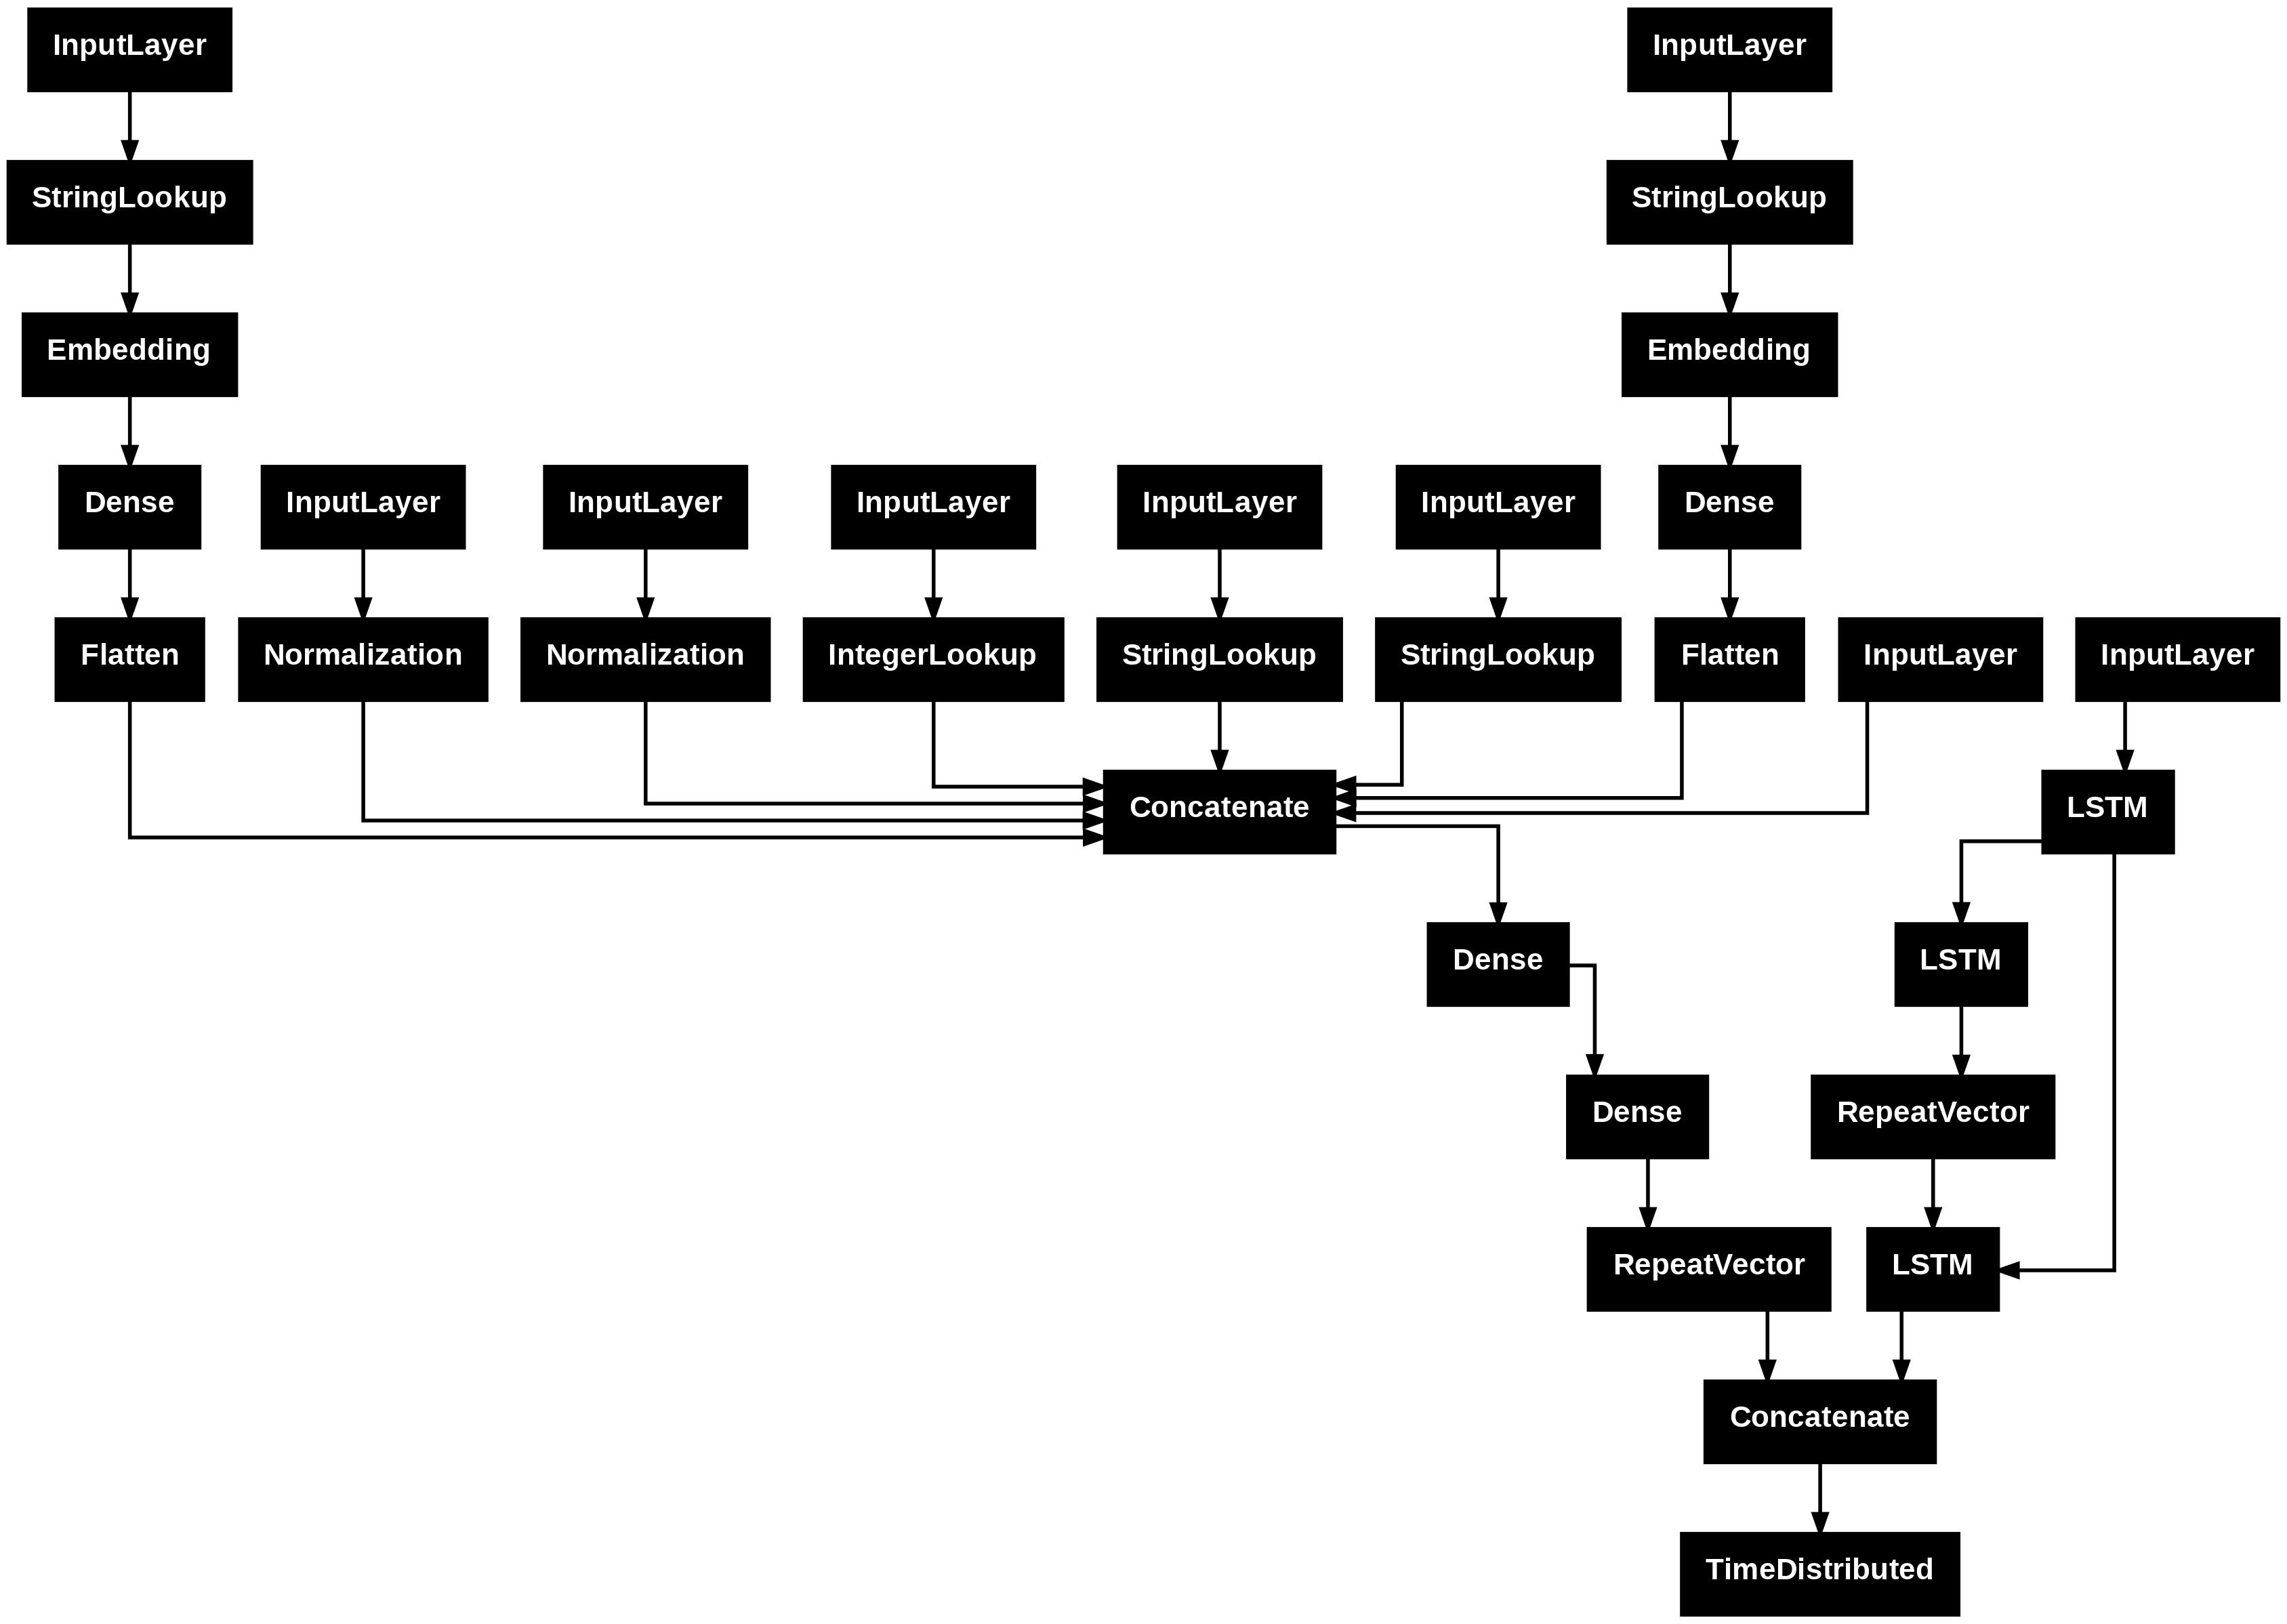

In [28]:
tf.keras.utils.plot_model(model)

In [29]:
model.predict(ds_train.batch(1).take(1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[[-0.6388949 , -0.25082928,  0.9898176 ],
        [-0.670571  , -0.26124048,  1.0063217 ],
        [-0.6946232 , -0.26949137,  1.0174901 ],
        [-0.7121572 , -0.27602798,  1.024504  ]]], dtype=float32)

## 6. Обучение модели

In [30]:
METRICS = [
    tf.keras.metrics.MeanAbsoluteError(name="mae"),
    tf.keras.metrics.MeanAbsolutePercentageError(name="mape"),
    tf.keras.metrics.MeanSquaredError(name="mse"),
    tf.keras.metrics.RootMeanSquaredError(name="rmse")
]

In [31]:
i = 2
model_path = f"models/autoencoder_v{i}.keras"
history_path = f"models/autoencoder_training_history_v{i}.joblib"

disk_path = "/content/drive/MyDrive/ML_projects/08_anomaly_detection/"
checkpoints_path = disk_path + f'data/06_model_output/initial_weights_{i}.weights.h5'

BATCH_SIZE = 128

regenerate = False
if regenerate:
    initial_weights = os.path.join(tempfile.mkdtemp(), checkpoints_path)

    lstm_model = get_model(df_stat, model_type="autoencoder")
    lstm_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.Huber(),
        metrics=METRICS
    )
    lstm_model.load_weights(initial_weights)

    n_epochs = 200
    steps_per_epoch=239
    batch_size = BATCH_SIZE
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-2 * 0.95**epoch
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        min_delta=1e-06,
        verbose=1,
        mode="min",
        restore_best_weights=True,
    )

    history = lstm_model.fit(
        ds_train.shuffle(1000).batch(batch_size),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=ds_valid.batch(batch_size),
        batch_size=batch_size,
        verbose=1,
        callbacks=[reduce_lr, early_stopping],
        shuffle=True,
    )
    lstm_model.save(PATH + model_path)
    joblib.dump(history, PATH + history_path)
else:
    from_disk = True
    if from_disk:
        path = disk_path
    else:
        path = PATH
    lstm_model = tf.keras.models.load_model(path + model_path)
    history = joblib.load(path + history_path)

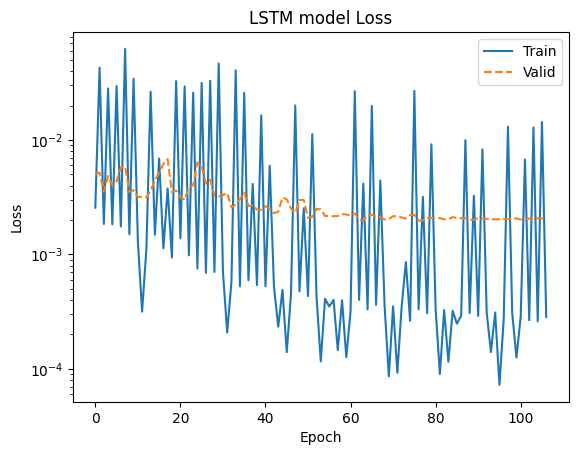

In [32]:
plot_loss(history)

* Модель была предобучена.

In [33]:
results = lstm_model.evaluate(
    ds_train.batch(batch_size=BATCH_SIZE),
    batch_size=BATCH_SIZE,
    verbose=0
)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0003


In [34]:
baseline_results = lstm_model.evaluate(
    ds_valid.batch(batch_size=BATCH_SIZE),
    batch_size=BATCH_SIZE,
    verbose=0
)
for name, value in zip(lstm_model.metrics_names, baseline_results):
  print(f'{name} : {value}')

loss : 0.001971742371097207
compile_metrics : 0.02142379805445671


In [35]:
save_weights = False
if save_weights:
  lstm_model.save_weights(checkpoints_path)

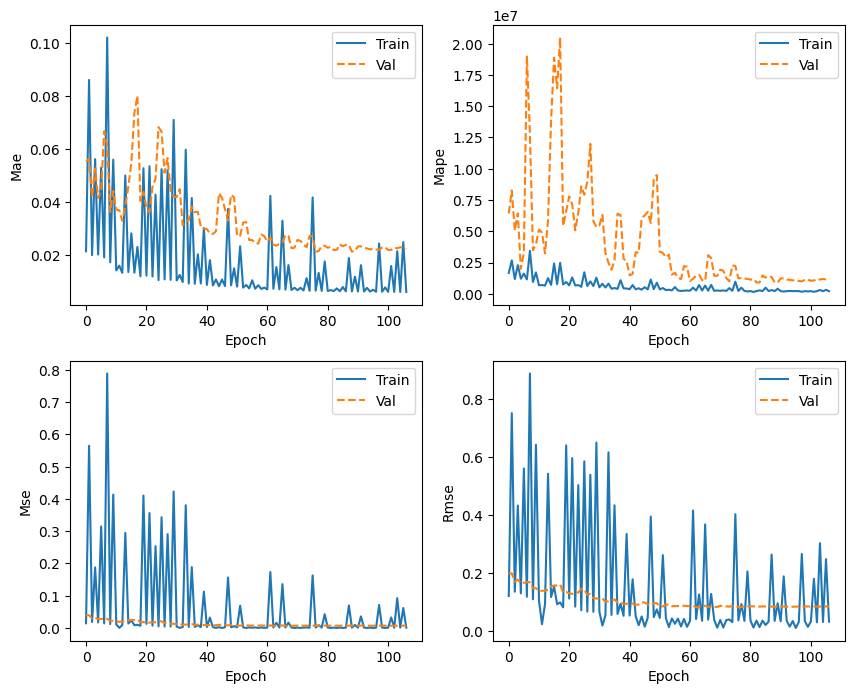

In [36]:
plot_metrics(history)

## 7. Отбор кандидатов для идеальной модели LSTM.

Предсказание идеального текущего значения по трем предшествующим периодам.

In [37]:
results = lstm_model.predict(ds_train.batch(BATCH_SIZE))
results.shape

240/240 ━━━━━━━━━━━━━━━━━━━━ 56s 231ms/step


(30684, 4, 3)

In [38]:
train_df = pd.read_parquet("/content/anomaly-detection/data/03_primary/train_df.parquet.gzip")
if type(train_df.iloc[0, -1]) == np.ndarray:
  train_df["LSTM input"] = train_df["LSTM input"].apply(lambda x: [list(i) for i in x])

print(f"train_df.shape = {train_df.shape}\n")
train_df.sample(2)

train_df.shape = (30684, 15)



,object index,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта,Группа этажность объекта,Улица,Дата постройки 2,Группа год постройки,Группа общая площадь объекта,seq index,LSTM input
20998,3026,"г Уфа, ул. Пархоменко, д.104 корп.1",Многоквартирный дом,14014054,1,5.0,1973-01-01,2798.61,5-9 этажей,ул. Пархоменко,1973-01-01,1959-1989 гг.,2800,4,"[[0.15550676378772113, 0.31116998547132724, 1...."
333,33,"г Уфа, б-р. Ибрагимова, д.37 корп.3",Многоквартирный дом,196066,1,9.0,2013-01-01,6366.20,5-9 этажей,б-р. Ибрагимова,2013-01-01,2011-2024 гг.,8900,10,"[[0.03492043895747599, 1.0, 0.0], [0.024447777..."


In [39]:
df = train_df["LSTM input"].apply(lambda x: pd.Series(np.array(x).T[0].tolist()))
df.values.shape

(30684, 4)

* Исходим из того, что 30% от выборки, которые плохо поддаются моделированию - аномалии.
* На адекватных 70% обучим эталонную модель предсказания потребления теплоэнергии в четвертом периоде на основе трех предшествующих.

In [40]:
a = abs(df.values - results[:, :, 0]).mean(axis=1) / df.values.mean(axis=1)
q = np.quantile(a, 0.7)
q

0.12699017697385806

* Точка отсечения - абсолютная ошибка предсказания потребления объекта выше 12.7%

In [41]:
selected_inputs_df = train_df[a < q]

print(f"selected_inputs_df.shape = {selected_inputs_df.shape}\n")
selected_inputs_df.sample(2)

selected_inputs_df.shape = (21479, 15)



,object index,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта,Группа этажность объекта,Улица,Дата постройки 2,Группа год постройки,Группа общая площадь объекта,seq index,LSTM input
29982,4402,"г Уфа, ул. Юрия Гагарина, д.12",Многоквартирный дом,802019,0,9.0,1994-01-01,5817.7,5-9 этажей,ул. Юрия Гагарина,1994-01-01,1990-2000 гг.,5900,4,"[[0.07247873799725651, 0.5267482677960414, 1.0..."
26429,3784,"г Уфа, ул. Сельская Богородская, д.45",Многоквартирный дом,110681,0,5.0,1975-01-01,4561.4,5-9 этажей,ул. Сельская Богородская,1975-01-01,1959-1989 гг.,5900,2,"[[0.12803333333333333, 0.20051562544511864, 1...."


In [42]:
save = False
if save:
  disk = "/content/drive/MyDrive/ML_projects/08_anomaly_detection/data/03_primary/"
  selected_inputs_df.to_parquet(f"{disk}selected_inputs_df.parquet.gzip", compression="gzip")

## 8. Эталонная модель

In [43]:
MODEL_TYPE = "ethalon_model"

### 8.1. Формирование датасета

In [44]:
valid_et = selected_inputs_df.sample(frac=0.2, random_state=25)
train_ind = list(set(selected_inputs_df.index) - set(valid_et.index))
train_et = selected_inputs_df.loc[train_ind, :]

train_et.shape, valid_et.shape

((17183, 15), (4296, 15))

In [45]:
%%time
model_type = MODEL_TYPE

generator = Generator(model_type)
ds_train_et = generator.get_tf_dataset(train_et)
ds_valid_et = generator.get_tf_dataset(valid_et)

ds_train_et.batch(1).take(1)

CPU times: user 88.7 ms, sys: 0 ns, total: 88.7 ms
Wall time: 87.8 ms


<_TakeDataset element_spec=({'n_floors': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'area': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'area_group': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'object_type': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'floor_group': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'year_group': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'street': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'gvs': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'LSTM input': TensorSpec(shape=(None, 3, 3), dtype=tf.float64, name=None)}, TensorSpec(shape=(None, 1, 3), dtype=tf.float64, name=None))>

### 8.2. Модель

In [46]:
model = get_model(selected_inputs_df, model_type)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ object_type (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_prep          │ (None, 1)              │              0 │ object_type[0][0]      │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_prep               │ (None, 1)              │              0 │ street[0][0]           │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_emb           │ (None, 1, 4)           │             64 │ object_type_prep[0][0] │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_emb (Embedding)    │ (None, 1, 15)          │          3,075 │ street_prep[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_dense (Dense) │ (None, 1, 2)           │             10 │ object_type_emb[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ floor_group (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ year_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_dense (Dense)      │ (None, 1, 8)           │            128 │ street_emb[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM input (InputLayer)   │ (None, 3, 3)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors_prep             │ (None, 1)              │              3 │ n_floors[0][0]         │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_prep (Normalization) │ (None, 1)              │              3 │ area[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group_prep           │ (None, 11)             │              0 │ area_group[0][0]       │
│ (IntegerLookup)           │                        │                │                        │
├──────────────────────

 Total params: 7,766 (30.34 KB)

 Trainable params: 7,760 (30.31 KB)

 Non-trainable params: 6 (32.00 B)

### 8.3. Обучение модели

In [47]:
i = 1
model_path = f"models/ethalon_model_v{i}.keras"
history_path = f"models/ethalon_model_training_history_v{i}.joblib"

disk_path = "/content/drive/MyDrive/ML_projects/08_anomaly_detection/"
checkpoints_path = disk_path + f'data/06_model_output/ethalon_model_initial_weights_{i}.weights.h5'

BATCH_SIZE = 128

regenerate = False
if regenerate:
    initial_weights = os.path.join(tempfile.mkdtemp(), checkpoints_path)

    lstm_model = get_model(selected_inputs_df, model_type)
    lstm_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.Huber(),
        metrics=METRICS
    )
    lstm_model.load_weights(initial_weights)

    n_epochs = 200
    steps_per_epoch = 239
    batch_size = BATCH_SIZE
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-2 * 0.95**epoch
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        min_delta=1e-06,
        verbose=1,
        mode="min",
        restore_best_weights=True,
    )

    history = lstm_model.fit(
        ds_train_et.shuffle(1000).batch(batch_size),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=ds_valid_et.batch(batch_size),
        batch_size=batch_size,
        verbose=1,
        callbacks=[reduce_lr, early_stopping],
        shuffle=True,
    )
    lstm_model.save(PATH + model_path)
    joblib.dump(history, PATH + history_path)
else:
    from_disk = False
    if from_disk:
        path = disk_path
    else:
        path = PATH
    lstm_model = tf.keras.models.load_model(disk_path + model_path)
    history = joblib.load(disk_path + history_path)

### 8.4. Оценка модели

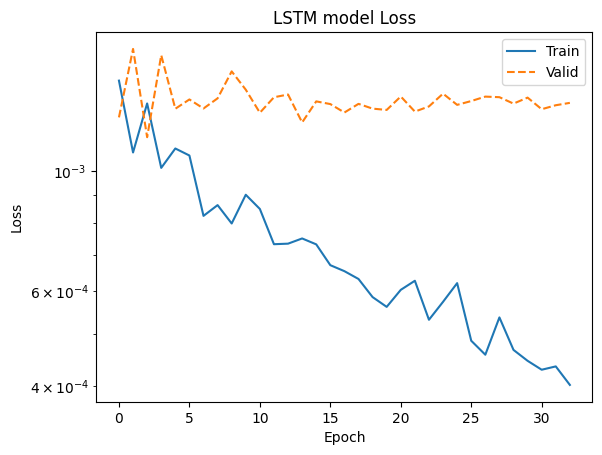

In [48]:
plot_loss(history)

In [49]:
results = lstm_model.evaluate(
    ds_train_et.batch(batch_size=BATCH_SIZE),
    batch_size=BATCH_SIZE,
    verbose=0
)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0012


In [50]:
baseline_results = lstm_model.evaluate(
    ds_valid_et.batch(batch_size=BATCH_SIZE),
    batch_size=BATCH_SIZE,
    verbose=0
)
for name, value in zip(lstm_model.metrics_names, baseline_results):
  print(f'{name} : {value}')

loss : 0.0011521239066496491
compile_metrics : 0.015403802506625652


In [51]:
save_weights = False
if save_weights:
  lstm_model.save_weights(checkpoints_path)

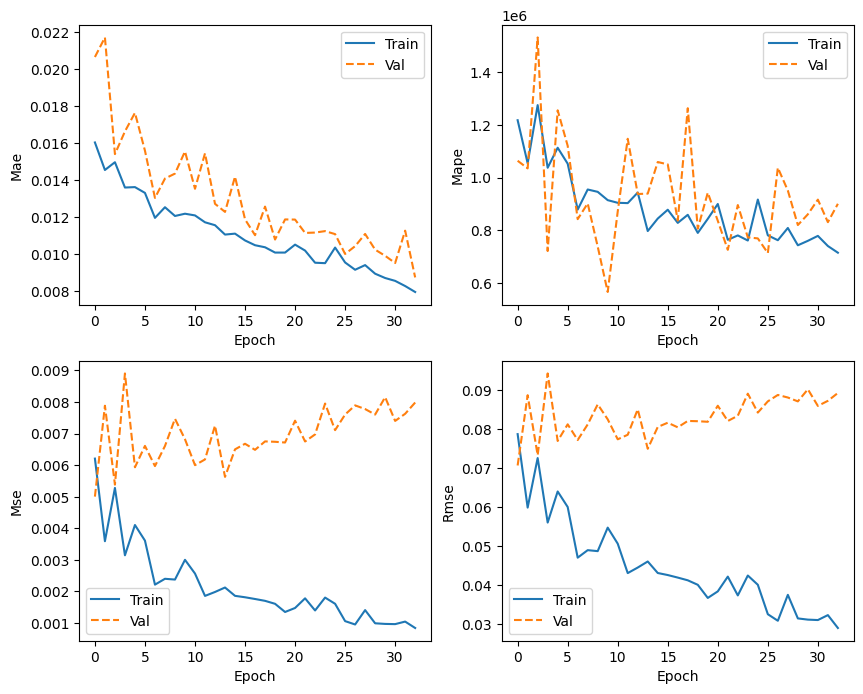

In [52]:
plot_metrics(history)

### 8.5. Оценка предсказаний эталонной модели

In [53]:
results_et = lstm_model.predict(ds_valid_et.batch(BATCH_SIZE))
results_et.shape

34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step


(4296, 1, 3)

In [54]:
df = valid_et["LSTM input"].apply(lambda x: pd.Series(np.array(x).T[0].tolist()))
df.values.shape

(4296, 4)

In [55]:
a = abs(df.values[:, -1] - results_et[:, :, 0].flatten()) / df.values[:, -1]
q = np.quantile(a, 0.7)
q

0.15262566001058345

In [56]:
pd.DataFrame(a).describe([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, .99])

,0
count,4296.000000
mean,0.294344
std,0.886652
min,0.000135
10%,0.020577
25%,0.049183
50%,0.099122
75%,0.166065
90%,0.360718
95%,1.415561


## 9. Детектирование аномалий

In [57]:
%%time
ds_et_all = generator.fit_transform(df_seq, temperature, df_stat, path=PATH, file_name="model_inputs_df.parquet.gzip")

CPU times: user 11.1 s, sys: 107 ms, total: 11.2 s
Wall time: 11.3 s


In [58]:
%%time
results_et_all = lstm_model.predict(ds_et_all.batch(BATCH_SIZE))
results_et_all.shape

352/352 ━━━━━━━━━━━━━━━━━━━━ 71s 203ms/step
CPU times: user 1min 9s, sys: 1.87 s, total: 1min 11s
Wall time: 1min 21s


(45040, 1, 3)

In [59]:
model_inputs_df = pd.read_parquet(f"{PATH}/data/03_primary/model_inputs_df.parquet.gzip")

if type(model_inputs_df.iloc[0, -1]) == np.ndarray:
  model_inputs_df["LSTM input"] = model_inputs_df["LSTM input"].apply(lambda x: [list(i) for i in x])

print(f"model_inputs_df.shape = {model_inputs_df.shape}\n")
model_inputs_df.sample(2)

model_inputs_df.shape = (45040, 15)



,object index,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта,Группа этажность объекта,Улица,Дата постройки 2,Группа год постройки,Группа общая площадь объекта,seq index,LSTM input
10577,974,"г Уфа, ул. Архитектурная, д.3",Многоквартирный дом,110731,1,4.0,1958-01-01,2912.5,3-4 этажа,ул. Архитектурная,1958-01-01,до 1958 г,3400,11,"[[0.010926666666666666, 1.0, 0.0], [0.00869406..."
7133,588,"г Уфа, пр-кт Октября, д.88",Многоквартирный дом,16031729,1,5.0,1961-01-01,3344.6,5-9 этажей,пр-кт Октября,1961-01-01,1959-1989 гг.,3400,19,"[[0.11253864447086802, 0.1006839969469158, 1.0..."


In [60]:
df = model_inputs_df["LSTM input"].apply(lambda x: pd.Series(np.array(x).T[0].tolist()))
df.values.shape

(45040, 4)

In [61]:
a = abs(df.values[:, -1] - results_et_all[:, :, 0].flatten()) / df.values[:, -1]
q = np.quantile(a, 0.99)
q

27.649126009974456

In [62]:
pd.DataFrame(a).describe([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, .99])

,0
count,45040.000000
mean,1.889683
std,17.262171
min,0.000009
10%,0.034195
25%,0.090122
50%,0.206098
75%,0.457531
90%,2.394744
95%,6.949279


In [63]:
model_inputs_df["Индекс соответствия прогнозу"] = a

In [64]:
model_inputs_df[ model_inputs_df["Индекс соответствия прогнозу"] > q]

,object index,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта,Группа этажность объекта,Улица,Дата постройки 2,Группа год постройки,Группа общая площадь объекта,seq index,LSTM input,Индекс соответствия прогнозу
85,6,"г Уфа, б-р. Давлеткильдеева, д.1",Другое строение,242529,1,3.0,NaT,0.00,3-4 этажа,б-р. Давлеткильдеева,1960-01-01,1959-1989 гг.,1,6,"[[0.0025253772290809327, 1.0, 0.0], [0.00189, ...",38.445972
86,6,"г Уфа, б-р. Давлеткильдеева, д.1",Другое строение,242529,1,3.0,NaT,0.00,3-4 этажа,б-р. Давлеткильдеева,1960-01-01,1959-1989 гг.,1,7,"[[0.00189, 1.0, 0.0], [0.003154006243496358, 1...",43.169568
665,48,"г Уфа, б-р. Ибрагимова, д.63",Другое строение,162241,1,10.0,1987-01-01,0.01,10-12 этажей,б-р. Ибрагимова,1987-01-01,1959-1989 гг.,1,8,"[[0.014146776406035667, 1.0, 0.0], [0.00419888...",173.371347
666,48,"г Уфа, б-р. Ибрагимова, д.63",Другое строение,162241,1,10.0,1987-01-01,0.01,10-12 этажей,б-р. Ибрагимова,1987-01-01,1959-1989 гг.,1,9,"[[0.004198888888888889, 1.0, 0.0], [0.00380853...",74.755234
683,49,"г Уфа, б-р. Ибрагимова, д.82",Другое строение,19-075397,1,7.0,1986-01-01,0.01,5-9 этажей,б-р. Ибрагимова,1986-01-01,1959-1989 гг.,1,7,"[[0.04290830449826989, 0.48735150841808395, 1....",41.445450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43185,4310,"г Уфа, ул. Шафиева, д.6 корп.1",Другое строение,00229473,1,2.0,NaT,0.01,1-2 этажа,ул. Шафиева,1972-01-01,1959-1989 гг.,1,11,"[[0.003597777777777778, 1.0, 0.0], [0.00411758...",33.618986
43313,4323,"г Уфа, ул. Шмидта, д.41",Многоквартирный дом,218396,1,13.0,2015-01-01,14343.90,13 и более этажей,ул. Шмидта,2015-01-01,2011-2024 гг.,25000,6,"[[0.41911177170035674, 0.1006839969469158, 1.0...",28.064224
44803,4501,"г Уфа, ул. Юрия Гагарина, д.64/68",Другое строение,145070,1,1.0,2019-01-01,0.01,1-2 этажа,ул. Юрия Гагарина,2019-01-01,2011-2024 гг.,1,16,"[[0.02026111111111111, 0.27761160014813546, 1....",118.423116
44922,4516,"г Уфа, ул. Юрия Гагарина, д.80",Другое строение,1645655,1,3.0,NaT,0.01,3-4 этажа,ул. Юрия Гагарина,1991-01-01,1990-2000 гг.,1,8,"[[0.020631001371742112, 1.0, 0.0], [0.0126, 1....",37.379445
